In [79]:
# Imports
import gym
import QDgym_extended
import numpy as np
import scipy.ndimage as ndimage
from util import modify, calculate_arc
import math

# np.random.seed(123)

def decode_genotype(genotype):
    """genotype: shape (24,) array, 3 parameters for each of the 8 motors.
    each motor genotype in the form of (duty_cycle, phase, scale).

    duty_cycle : [0, 1)
    phase: [0, 1)
    scale: [0, 1]
    """
    
    targets = -np.ones((100, 8), dtype=np.float32)
    phase = np.int32(genotype[1::3] * 100)
    for index, duty_cycle in enumerate(genotype[0::3]):
        start = phase[index]
        end = int(duty_cycle*101) + start
        targets[start: end, index] = 1
        if end > 100:
            targets[: end-100, index] = 1

    guassian_kernel = np.array([0.0008880585, 0.0015861066, 0.00272177, 0.00448744, 0.007108437, 0.010818767, 
                                0.015820118, 0.022226436, 0.03000255, 0.03891121, 0.048486352, 0.058048703, 
                                0.0667719, 0.073794365, 0.078357555, 0.07994048, 0.078357555, 0.073794365, 
                                0.0667719, 0.058048703, 0.048486352, 0.03891121, 0.03000255, 0.022226436, 
                                0.015820118, 0.010818767, 0.007108437, 0.00448744, 0.00272177, 0.0015861066, 
                                0.0008880585], dtype=np.float32)

    targets = ndimage.convolve1d(targets, guassian_kernel, axis=0, mode="wrap")
    
    scales = np.float32(genotype[2::3])
    return targets, scales


kds = np.array([0.072, 0.082, 0.072, 0.082, 0.072, 0.082, 0.072, 0.082], dtype=np.float32)
kps = np.array([1.43, 1.637, 1.43, 1.637, 1.43, 1.637, 1.43, 1.637], dtype=np.float32)
constants = np.array([0.0, 1.857176, 0.0, -1.857176, 0.0, -1.857176, 0.0, 1.857176], dtype=np.float32)

In [137]:
modify(10, 1.0)
env = gym.make("QDCustomAntBulletEnv-v0", robot_file="custom_ant.xml")

genotypes = np.load("selected_genotypes.npy")

xys = np.zeros((6, 420, 2), dtype=np.float32)

for i, genotype in enumerate(genotypes):
    targets, scales = decode_genotype(genotype)
    positions = np.zeros(8, dtype=np.float32)
    speeds = np.zeros(8, dtype=np.float32)

    state = env.reset()
    done = False

    for n in range(420):
        target = targets[n % 100]
        for index, joint in enumerate(env.ordered_joints):
            positions[index], speeds[index] = joint.current_position()

        action = np.clip(constants + scales*target - positions*kps - kds*speeds, -1, 1)
        state, reward, done, info = env.step(action)

        x, y, z = env.robot_body.pose().xyz()
        xys[i, n, 0] = x
        xys[i, n, 1] = y

env.close()


argv[0]=
argv[0]=


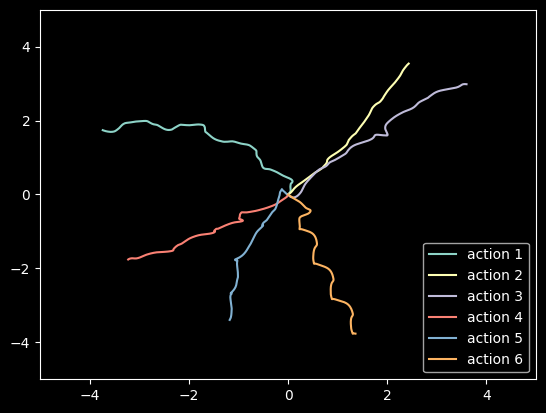

In [138]:
import matplotlib.pyplot as plt

x = np.zeros(400, dtype=np.float32)
y = np.zeros(400, dtype=np.float32)


for index, xy in enumerate(xys):
    x[:] = xy[20:, 0]
    y[:] = xy[20:, 1]

    x -= xy[20, 0]
    y -= xy[20, 1]

    plt.plot(x, y, label=f"action {index+1}")

plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend()
plt.show()




# x_, y_ = xy[20:n].T
# # plt.scatter(x_, y_)
# plt.plot(x_, y_)
# x_span = np.max(x_) - np.min(x_)
# y_span = np.max(y_) - np.min(y_)
# if x_span > y_span:
#     x_ref = np.max(x)
#     y_ref = np.min(y) + x_span
# else:
#     y_ref = np.max(y)
#     x_ref = np.min(x) + y_span
# plt.scatter(x_ref, y_ref)
# plt.show()

# x, y, z = env.robot_body.pose().xyz()
# print(fitness)
# print(round(x, 4), round(y, 4), round(z, 4))
# print("distance:", round(np.sqrt(x**2 + y**2), 4))

# image = env.render(mode="rgb_array")
# plt.imshow(image)
# # plt.savefig("image.png", dpi=500)
# plt.show()
# env.close()


In [139]:
arcs = np.zeros((6, 3), dtype=np.float32)

trajectories = np.zeros((6, 2, 400))

for index, xy in enumerate(xys):
    x = np.zeros(400, dtype=np.float32)
    y = np.zeros(400, dtype=np.float32)
    x[:] = xy[20:, 0]
    y[:] = xy[20:, 1]

    x -= xy[20, 0]
    y -= xy[20, 1]

    trajectories[index, 0] = x
    trajectories[index, 1] = y

    v, w, phi = calculate_arc(np.mean(x.reshape(-1, 4), axis=-1), 
                              np.mean(y.reshape(-1, 4), axis=-1),
                              np.linspace(0, 4, 100))
    arcs[index] = v, w, phi




In [140]:
# np.save("arcs.npy", arcs)
# np.save("trajectories.npy", trajectories)
# np.save("arcs_2.npy", arcs)
# np.save("trajectories_2.npy", trajectories)

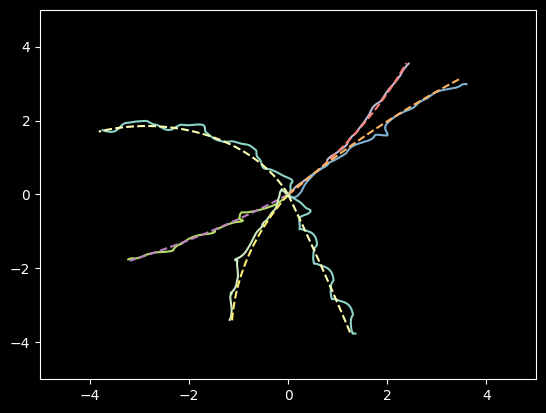

In [141]:

for arc, trajectory in zip(arcs, trajectories):
    x, y = trajectory
    v, w, phi = arc
    
    theta = np.linspace(0, 4, 100)*w + phi
    arc_x = v / w * (np.sin(theta) - math.sin(phi))
    arc_y = v / w * (math.cos(phi) - np.cos(theta))


    plt.plot(x, y, label=f"action {index+1}")
    plt.plot(arc_x, arc_y, linestyle="--")

plt.xlim((-5, 5))
plt.ylim((-5, 5))
# plt.legend()
plt.show()

In [172]:
modify(10, 0.7)
env = gym.make("QDCustomAntBulletEnv-v0", robot_file="custom_ant.xml")

genotypes = np.load("selected_genotypes.npy")

xys = np.zeros((6, 420, 2), dtype=np.float32)

for i, genotype in enumerate(genotypes):
    targets, scales = decode_genotype(genotype)
    positions = np.zeros(8, dtype=np.float32)
    speeds = np.zeros(8, dtype=np.float32)

    state = env.reset()
    done = False

    for n in range(420):
        target = targets[n % 100]

        # target[1] = -1 # damaged

        for index, joint in enumerate(env.ordered_joints):
            positions[index], speeds[index] = joint.current_position()

        action = np.clip(constants + scales*target - positions*kps - kds*speeds, -1, 1)
        state, reward, done, info = env.step(action)

        x, y, z = env.robot_body.pose().xyz()
        xys[i, n, 0] = x
        xys[i, n, 1] = y

env.close()

argv[0]=
argv[0]=


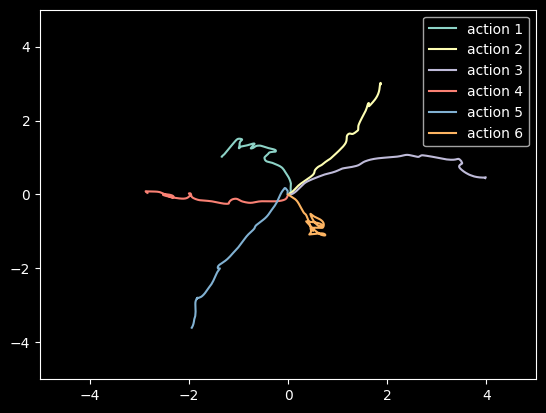

In [173]:
x = np.zeros(400, dtype=np.float32)
y = np.zeros(400, dtype=np.float32)
new_trajectories = np.zeros((6, 2, 400))

for index, xy in enumerate(xys):
    x[:] = xy[20:, 0]
    y[:] = xy[20:, 1]

    x -= xy[20, 0]
    y -= xy[20, 1]

    new_trajectories[index, 0] = x
    new_trajectories[index, 1] = y

    plt.plot(x, y, label=f"action {index+1}")

plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend()
plt.show()

In [163]:
# np.save("new_trajectories2.npy", new_trajectories)